In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
import json

# Companies

## Feature Engineering
After one-hot encoding, the companies dataset has 995 columns, so it's necessary to perform dimensionality reduction before building the model.

In [61]:
pd.set_option('display.max_columns', None)
companies_df = pd.read_csv("data/companies.csv")
companies_df.head()
companies_df.dropna(inplace=True)
cdf = companies_df.copy()

In [62]:
companies_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10584 entries, 0 to 10872
Columns: 998 entries, Annual Revenue to Close YN
dtypes: float64(2), int64(996)
memory usage: 80.7 MB


In [63]:
# Drop some columns if present
if "Record ID" in companies_df.columns:
    companies_df = companies_df.drop(columns=["Record ID"])

In [64]:
# Extract features and target
X = companies_df.drop(columns=["Close YN"])
y = companies_df["Close YN"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

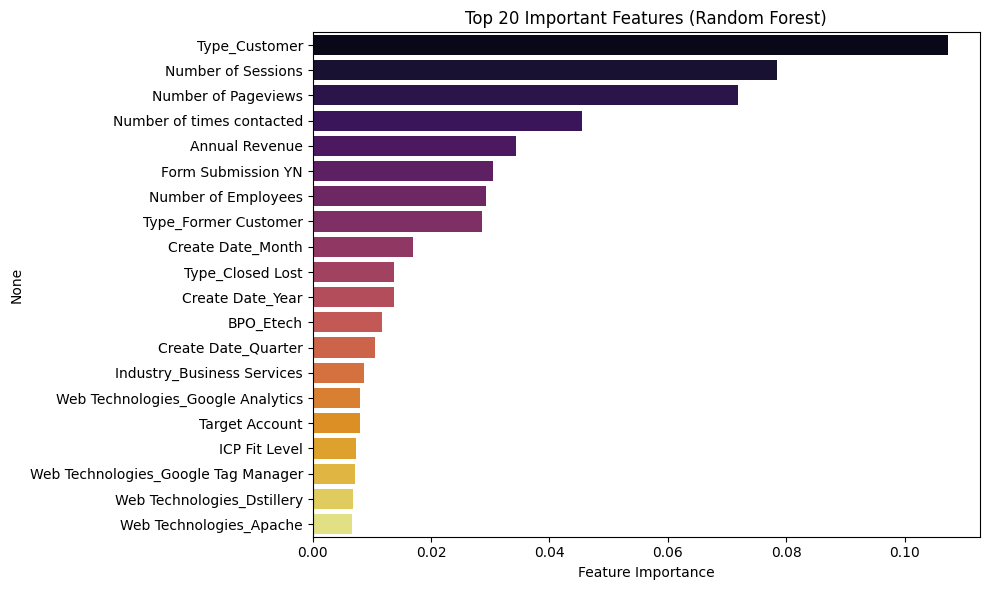

In [65]:
# Train RandomForest to get feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Top 20 features
importances = pd.Series(rf.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(20)

# Plot top 20 feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index, hue = top_features.index, palette="inferno")
plt.title("Top 20 Important Features (Random Forest)")
plt.xlabel("Feature Importance")
plt.tight_layout()
plt.show()

### Feature Importance Analysis (Random Forest)

The bar chart you saw highlights the **Top 20 most important features** for predicting whether a deal is closed (`Close YN`). Here's a summary of what the key features indicate:

| **Feature** | **Interpretation** |
|-------------|--------------------|
| `Type_Customer`, `Type_Former Customer` | The type of customer has a significant impact on the likelihood of closing a deal. For example, returning customers or those categorized as “Customer” may be more likely to close. |
| `Number of Sessions`, `Number of Pageviews` | These engagement metrics are strong indicators of customer interest. More sessions and pageviews often correlate with higher conversion likelihood. |
| `Form Submission YN` | Whether the customer submitted a form can reflect strong buying intent. Lack of form submission may indicate lower interest. |
| `Revenue Category`, `Company Size Category` | Company size and revenue level are positively related to purchasing power and decision-making capability. Larger and higher-revenue companies tend to convert more easily. |
| `Web Technologies_*` | The presence of certain deployed web technologies may indicate technical maturity or readiness, which contributes to a higher probability of closing a deal. |

---

#### Summary

> These top features not only reflect who the customer is (company profile), but also **how actively they engage** with the product and **what signals they send** during the journey. This makes them powerful predictors in a sales enablement model.


## Xgboost

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2107
           1       0.83      0.50      0.62        10

    accuracy                           1.00      2117
   macro avg       0.92      0.75      0.81      2117
weighted avg       1.00      1.00      1.00      2117

Confusion Matrix:
 [[2106    1]
 [   5    5]]
AUC Score: 0.9735643094447081


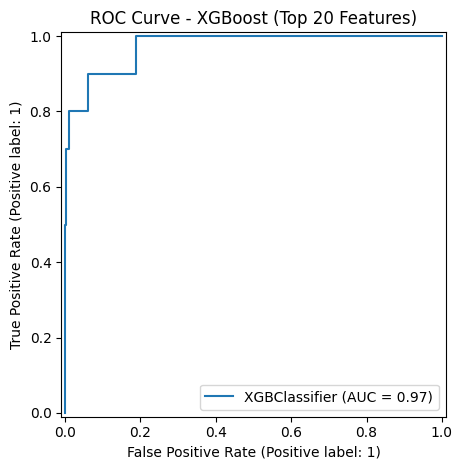

In [66]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

X_selected = companies_df[top_features.index]
y = companies_df["Close YN"]

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("AUC Score:", roc_auc_score(y_test, y_proba))

RocCurveDisplay.from_estimator(xgb_model, X_test, y_test)
plt.title("ROC Curve - XGBoost (Top 20 Features)")
plt.tight_layout()
plt.show()

This block trains an XGBoost binary classification model using the top 20 features selected from feature importance. 

The dataset is highly imbalanced, with only 0.5% of deals marked as “Closed Won”. The model becomes biased toward predicting “not closed” because it's the dominant class. The recall for closed deals is only 60%, which means many real customers are missed. Missing positive predictions could mean losing real sales opportunities.

Classification Report with Balanced Class Weight:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      2107
           1       0.57      0.80      0.67        10

    accuracy                           1.00      2117
   macro avg       0.79      0.90      0.83      2117
weighted avg       1.00      1.00      1.00      2117

Confusion Matrix:
 [[2101    6]
 [   2    8]]
AUC Score: 0.9928334124347413


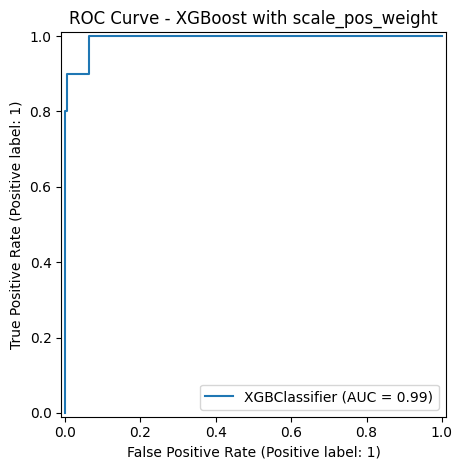

In [67]:
positive_count = sum(y == 1)
negative_count = sum(y == 0)
scale_weight = negative_count / positive_count

xgb_model_balanced = XGBClassifier(
    eval_metric='logloss',
    scale_pos_weight=scale_weight,
    random_state=42
)

xgb_model_balanced.fit(X_train, y_train)

y_pred_bal = xgb_model_balanced.predict(X_test)
y_proba_bal = xgb_model_balanced.predict_proba(X_test)[:, 1]

print("Classification Report with Balanced Class Weight:\n", classification_report(y_test, y_pred_bal))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_bal))
print("AUC Score:", roc_auc_score(y_test, y_proba_bal))

RocCurveDisplay.from_estimator(xgb_model_balanced, X_test, y_test)
plt.title("ROC Curve - XGBoost with scale_pos_weight")
plt.tight_layout()
plt.show()

While recall has improved, precision dropped, meaning the model catches more positives but at the cost of more false alarms.

## Clustering & Visualization
I used the top 20 most important features from the classification task and applied KMeans clustering with 3 clusters. The features were standardized and visualized with PCA.

In [70]:
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "8"

# Select top features used earlier
X_cluster = companies_df[top_features.index].copy()

# Standardize features before clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

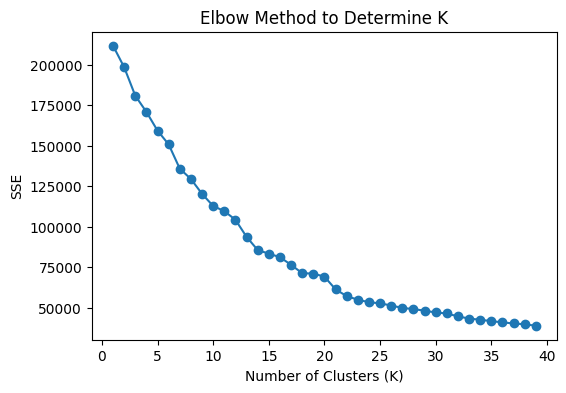

In [71]:
sse = []
K_range = range(1, 40)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(K_range, sse, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("SSE")
plt.title("Elbow Method to Determine K")
plt.show()

In [72]:
# Fit KMeans models
kmeans_4 = KMeans(n_clusters=4, random_state=42)
companies_df["Cluster_K4"] = kmeans_4.fit_predict(X_scaled)

kmeans_14 = KMeans(n_clusters=14, random_state=42)
companies_df["Cluster_K14"] = kmeans_14.fit_predict(X_scaled)

In [73]:
# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
pca_df["Cluster_K4"] = companies_df["Cluster_K4"]
pca_df["Cluster_K14"] = companies_df["Cluster_K14"]

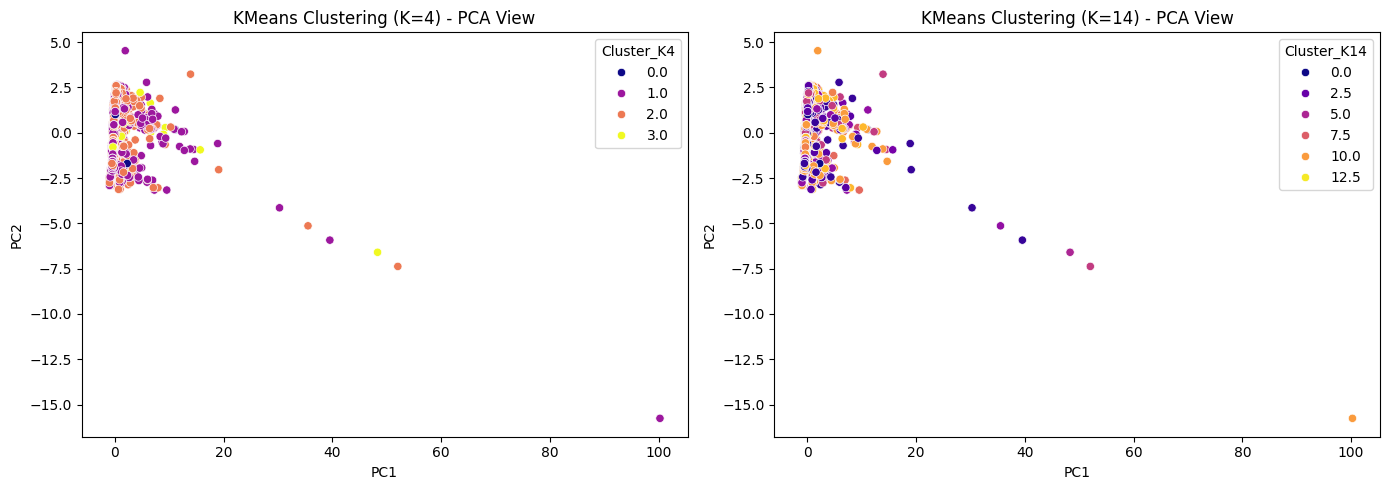

In [74]:
# Plot the PCA views for K=4 and K=14
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Cluster_K4", palette="plasma", ax=axes[0])
axes[0].set_title("KMeans Clustering (K=4) - PCA View")

sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Cluster_K14", palette="plasma", ax=axes[1])
axes[1].set_title("KMeans Clustering (K=14) - PCA View")

plt.tight_layout()
plt.show()

Considering our project goal of Customer Segmentation and High-Value Customer Group Identification, I recommend using K=4 clustering. This is because K=4 provides a clearer and more interpretable customer structure, which is easier to support business strategy, sales planning, and resource allocation. The segmentation result with K=4 is good enough to distinguish between ordinary customers and potential high-value customers without over-complicating the analysis.

In [75]:
# Analyze Close YN and ICP Fit Level distribution in K=4 clusters
close_dist = companies_df.groupby("Cluster_K4")["Close YN"].value_counts(normalize=True).unstack()

if "ICP Fit Level" in companies_df.columns:
    icp_dist = companies_df.groupby("Cluster_K4")["ICP Fit Level"].value_counts(normalize=True).unstack()
else:
    icp_dist = None

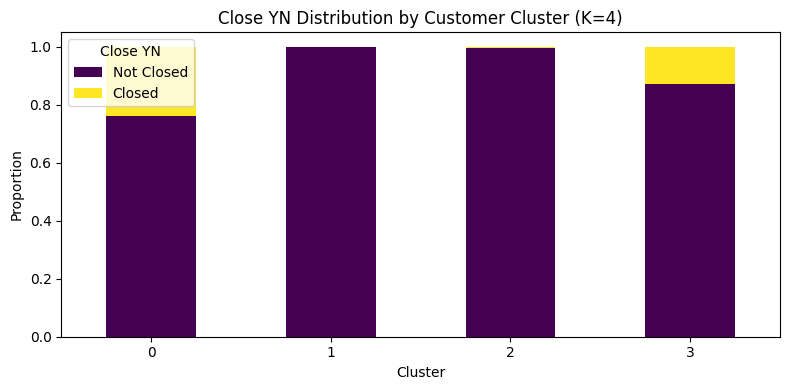

In [76]:
# Plot Close YN Distribution
close_dist.plot(kind="bar", stacked=True, colormap="viridis", figsize=(8, 4))
plt.title("Close YN Distribution by Customer Cluster (K=4)")
plt.ylabel("Proportion")
plt.xlabel("Cluster")
plt.xticks(rotation=0)
plt.legend(title="Close YN", labels=["Not Closed", "Closed"])
plt.tight_layout()
plt.show()

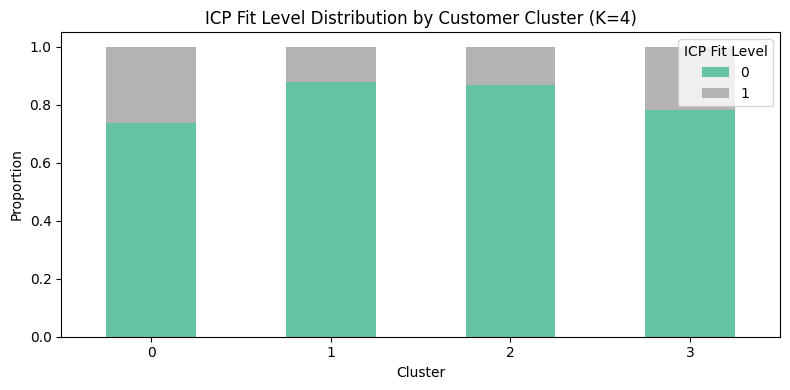

In [77]:
# Plot ICP Fit Level Distribution if available
if icp_dist is not None:
    icp_dist.plot(kind="bar", stacked=True, colormap="Set2", figsize=(8, 4))
    plt.title("ICP Fit Level Distribution by Customer Cluster (K=4)")
    plt.ylabel("Proportion")
    plt.xlabel("Cluster")
    plt.xticks(rotation=0)
    plt.legend(title="ICP Fit Level")
    plt.tight_layout()
    plt.show()

Cluster 0 & 3 = High-Value Customer Group → Highest conversion rate + Highest ICP ratio → Core target for sales efforts.

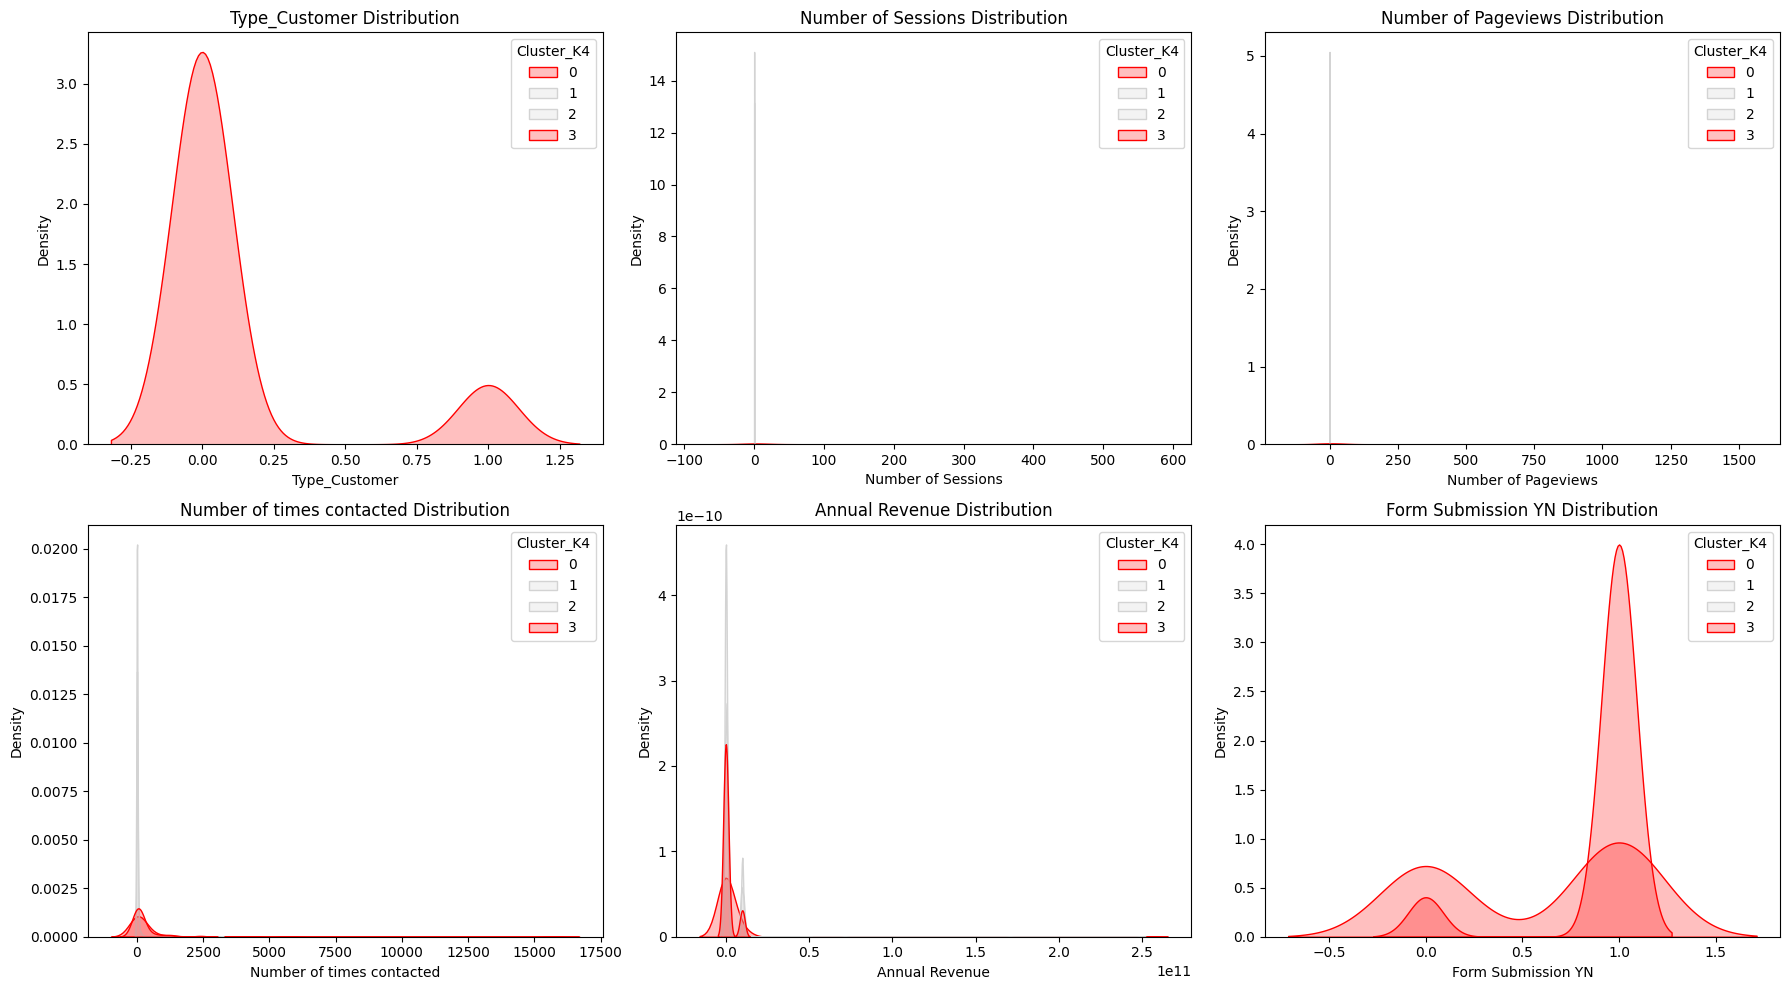

In [80]:
# Visualize important features distribution in Cluster 2 vs other clusters
important_features = top_features.index[:6]  # Select top 6 features for visualization

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
palette = {0: "red", 1: "lightgray", 2: "lightgray", 3: "red"}

for i, feature in enumerate(important_features):
    row = i // 3
    col = i % 3
    sns.kdeplot(
        data=companies_df,
        x=feature,
        hue="Cluster_K4",
        fill=True,
        common_norm=False,
        palette=palette,
        ax=axes[row, col],
        warn_singular=False
    )
    axes[row, col].set_title(f"{feature} Distribution")
    
plt.tight_layout()
plt.show()

## Companies & Deals

In [174]:
deals_df = pd.read_csv("data/deals.csv")
tickets_df = pd.read_csv("data/tickets.csv") 
with open("mappings.json", "r") as f:
    mappings = json.load(f)

In [175]:
deals_df.fillna(0, inplace=True)


In [176]:
deals_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593 entries, 0 to 592
Data columns (total 38 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Weighted amount                                      593 non-null    float64
 1   Days to close                                        593 non-null    float64
 2   Deal Score                                           593 non-null    float64
 3   Close Date                                           593 non-null    object 
 4   Record ID                                            593 non-null    int64  
 5   Deal probability                                     593 non-null    float64
 6   Is Closed Won                                        593 non-null    int64  
 7   Last Activity Date                                   593 non-null    object 
 8   Is closed lost                                       593 non-null    i

In [177]:
tickets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 13 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Ticket status                          56 non-null     int64  
 1   Ticket ID                              56 non-null     int64  
 2   Create date_Year                       56 non-null     int64  
 3   Create date_Month                      56 non-null     int64  
 4   Create date_Quarter                    56 non-null     int64  
 5   Implementation Duration Days           39 non-null     float64
 6   Ticket status_Won                      56 non-null     int64  
 7   Ticket status_Lost                     56 non-null     int64  
 8   Response time hours                    56 non-null     float64
 9   Training Completion Count              56 non-null     int64  
 10  Requirements for the Trial_Onboarding  56 non-null     int64  
 11  Requirem

In [178]:
company_to_deals = mappings.get("CompanyToDeals", {})
for key, value in list(company_to_deals.items())[:5]:
    print(f"Company Record ID: {key} --> Deal Record IDs: {value}")

Company Record ID: 17771181752 --> Deal Record IDs: ['29547238775']
Company Record ID: 9364308545 --> Deal Record IDs: ['9794988112']
Company Record ID: 9366087515 --> Deal Record IDs: ['9817334075']
Company Record ID: 9366136383 --> Deal Record IDs: ['9817334090']
Company Record ID: 9366140751 --> Deal Record IDs: ['9817320072']


In [179]:
# Expand the mapping dictionary into a list of (Company_Record_ID, Deal_Record_ID) pairs
mapping_list = []
for company_id, deal_list in company_to_deals.items():
    for deal_id in deal_list:
        mapping_list.append({"Company_Record_ID": company_id, "Deal_Record_ID": deal_id})

# Convert the list to a DataFrame
mapping_df = pd.DataFrame(mapping_list)

# Preview the mapping DataFrame
print("Mapping DataFrame preview:")
print(mapping_df.head())

Mapping DataFrame preview:
  Company_Record_ID Deal_Record_ID
0       17771181752    29547238775
1        9364308545     9794988112
2        9366087515     9817334075
3        9366136383     9817334090
4        9366140751     9817320072


In [180]:
# Merge the mapping DataFrame with deals data based on the deal identifier
# mapping_df.Deal_Record_ID should match deals_df['Record ID'] (which is the deal's unique ID)
deals_df["Record ID"] = deals_df["Record ID"].astype(str)
mapping_df["Deal_Record_ID"] = mapping_df["Deal_Record_ID"].astype(str)
deals_with_company = pd.merge(mapping_df, deals_df, left_on="Deal_Record_ID", right_on="Record ID", how="inner")

In [181]:
deals_with_company.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 582 entries, 0 to 581
Data columns (total 40 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Company_Record_ID                                    582 non-null    object 
 1   Deal_Record_ID                                       582 non-null    object 
 2   Weighted amount                                      582 non-null    float64
 3   Days to close                                        582 non-null    float64
 4   Deal Score                                           582 non-null    float64
 5   Close Date                                           582 non-null    object 
 6   Record ID                                            582 non-null    object 
 7   Deal probability                                     582 non-null    float64
 8   Is Closed Won                                        582 non-null    i

In [137]:
# Group the merged deals data by the company (using the mapping field 'Company_Record_ID')
# and calculate aggregate metrics for each company.
deals_agg = deals_with_company.groupby("Company_Record_ID").agg(
    Total_Deals_Count=pd.NamedAgg(column="Record ID", aggfunc="count"),
    Total_Deal_Amount=pd.NamedAgg(column="Amount", aggfunc="sum"),
    Average_Deal_Amount=pd.NamedAgg(column="Amount", aggfunc="mean"),
    Win_Rate=pd.NamedAgg(column="Is Closed Won", aggfunc="mean"),
    Average_Days_to_Close=pd.NamedAgg(column="Days to close", aggfunc="mean"),
    Last_Close_Date=pd.NamedAgg(column="Close Date", aggfunc="max")
).reset_index()

current_date = pd.to_datetime("today")
deals_agg["Recency"] = (current_date - pd.to_datetime(deals_agg["Last_Close_Date"])).dt.days
deals_agg.drop(columns=["Last_Close_Date"], inplace=True)
# Preview the aggregated metrics
print("Aggregated deals metrics by company:")
deals_agg.info()

Aggregated deals metrics by company:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338 entries, 0 to 337
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Company_Record_ID      338 non-null    object 
 1   Total_Deals_Count      338 non-null    int64  
 2   Total_Deal_Amount      338 non-null    float64
 3   Average_Deal_Amount    338 non-null    float64
 4   Win_Rate               338 non-null    float64
 5   Average_Days_to_Close  338 non-null    float64
 6   Recency                338 non-null    int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 18.6+ KB


In [138]:
cdf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10584 entries, 0 to 10872
Columns: 998 entries, Annual Revenue to Close YN
dtypes: float64(2), int64(995), object(1)
memory usage: 80.9+ MB


In [145]:
# Frequency is computed as the total number of deals per company (Total_Deals_Count).
# Monetary is computed as the total transaction amount per company (Total_Deal_Amount).
# For RFM analysis, we use quantile-based scoring (1-5 scale).

# Score Recency: lower recency (fewer days) is better. 
# Therefore, assign higher scores to lower Recency values.
deals_agg["R_Score"] = pd.qcut(deals_agg["Recency"], 5, labels=[5, 4, 3, 2, 1]).astype(int)

# Score Frequency: higher number of deals is better.
def assign_score(total_deals):
    if total_deals == 1:
        return 1
    elif 1 < total_deals <= 10:
        return 3
    else:  # total_deals > 10
        return 5

deals_agg["F_Score"] = deals_agg["Total_Deals_Count"].apply(assign_score)

# Score Monetary: higher total amount is better.
deals_agg["M_Score"] = pd.qcut(deals_agg["Total_Deal_Amount"], 5, labels=[1, 2, 3, 4, 5]).astype(int)

# Calculate overall RFM Score by summing individual scores.
deals_agg["RFM_Score"] = deals_agg["R_Score"] + deals_agg["F_Score"] + deals_agg["M_Score"]

In [147]:
# Calculate the 80th percentile (i.e., top 20% threshold) of the RFM_Score column.
threshold = deals_agg["RFM_Score"].quantile(0.8)

# Filter companies with RFM_Score greater than or equal to the threshold.
top_20_percent_customers = deals_agg[deals_agg["RFM_Score"] >= threshold]

# Preview the filtered results.
print("Top 20% customers based on RFM_Score:")
top_20_percent_customers

Top 20% customers based on RFM_Score:


,Company_Record_ID,Total_Deals_Count,Total_Deal_Amount,Average_Deal_Amount,Win_Rate,Average_Days_to_Close,Recency,R_Score,F_Score,M_Score,RFM_Score
4,10203327033,3,111800.0,37266.666667,0.666667,137.000000,-48,5,3,5,13
10,10348179895,1,50000.0,50000.000000,0.000000,596.000000,2,5,1,4,10
25,10558168700,1,50000.0,50000.000000,0.000000,272.000000,-61,5,1,4,10
30,10558210732,1,144000.0,144000.000000,0.000000,108.000000,59,4,1,5,10
31,10558217137,3,216000.0,72000.000000,0.000000,279.666667,16,5,3,5,13
...,...,...,...,...,...,...,...,...,...,...,...
312,9366168475,6,215000.0,35833.333333,0.333333,107.500000,467,2,3,5,10
318,9499343195,7,65000.0,9285.714286,0.857143,137.857143,198,3,3,4,10
319,9645904458,7,205000.0,29285.714286,0.428571,151.428571,13,5,3,5,13
327,9848087097,1,50000.0,50000.000000,0.000000,60.000000,9,5,1,4,10


Our approach leverages RFM analysis—a widely recognized technique that segments customers based on three key dimensions:  
Recency (R): This measures how recently a customer made their last transaction. A lower number of days since the last purchase indicates that the customer is still engaged and active with our brand. In our model, we score Recency inversely (i.e., the lower the number, the higher the score).  
Frequency (F): This reflects the total number of purchases made by a customer. A higher transaction frequency suggests greater customer loyalty and engagement. In our implementation, we either score this directly by quantiles or by applying a custom rule (e.g., customers with more than 10 transactions receive the highest score).  
Monetary (M): This represents the total amount spent by the customer over a period. Customers who contribute higher amounts are considered more valuable to the business. We score Monetary value using quantile-based scoring, where higher total spending results in a higher score.  
To identify our high-value customer group, we filter those customers who fall into the top 20% based on the composite RFM score. This segment represents customers with the most recent purchases, highest transaction frequency, and highest monetary contributions, making them our prime targets for strategic initiatives and further engagement.

In [129]:
cdf["Record ID"] = cdf["Record ID"].astype(str)
companies_enriched = pd.merge(cdf, deals_agg, left_on="Record ID", right_on="Company_Record_ID", how="left")
companies_enriched.dropna(inplace=True)
companies_enriched.info()

<class 'pandas.core.frame.DataFrame'>
Index: 313 entries, 29 to 10582
Columns: 1004 entries, Annual Revenue to Average_Days_to_Close
dtypes: float64(7), int64(995), object(2)
memory usage: 2.4+ MB


# Deals Prediction

In [249]:
deals_company = pd.merge(deals_with_company, cdf, left_on="Company_Record_ID", right_on="Record ID", how="inner")
df = deals_company.copy()

In [250]:
object_columns = df.select_dtypes(include=['object']).columns.tolist()
object_columns

['Company_Record_ID',
 'Deal_Record_ID',
 'Close Date',
 'Record ID_x',
 'Last Activity Date',
 'Create Date',
 'Last Modified Date',
 'Record ID_y']

In [251]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 549 entries, 0 to 548
Columns: 1038 entries, Company_Record_ID to Close YN
dtypes: float64(7), int64(1023), object(8)
memory usage: 4.3+ MB


In [252]:
df = df.select_dtypes(exclude=['object'])
df = df.drop(columns=["Is closed lost"])
df = df.drop(columns=["Forecast category_Closed won"])
df = df.drop(columns=["Deal probability"])
df = df.drop(columns=["Close YN"])
df = df.drop(columns=["Deal Score"])
df = df.drop(columns=["Deal Stage"])

In [253]:
# Calculate the class distribution in the target variable
deal_target_distribution = df["Is Closed Won"].value_counts().to_frame(name="Count")
deal_target_distribution["Percentage"] = round(100 * deal_target_distribution["Count"] / deal_target_distribution["Count"].sum(), 2)
deal_target_distribution

,Count,Percentage
Is Closed Won,,
0,403,73.41
1,146,26.59


In [254]:
print("Original shape of df:", df.shape)

Original shape of df: (549, 1024)


In [255]:
# Define features and label
X = df.drop(columns=["Is Closed Won"])
y = df["Is Closed Won"]

In [256]:
from sklearn.feature_selection import VarianceThreshold

# Remove features with very low variance (e.g., variance threshold = 0.01)
selector = VarianceThreshold(threshold=0.01)
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
df_numeric = X[numeric_cols]
df_numeric_reduced = pd.DataFrame(selector.fit_transform(df_numeric), columns=numeric_cols[selector.get_support()])
print("Shape after variance threshold filtering:", df_numeric_reduced.shape)

Shape after variance threshold filtering: (549, 202)


In [257]:
X = df_numeric_reduced.copy()

In [258]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y,
    test_size=0.2,
    random_state=42,
    stratify=y  # keep class distribution consistent
)

print("Initial train shape:", X_train.shape)
print("Initial test shape:", X_test.shape)

Initial train shape: (439, 202)
Initial test shape: (110, 202)


In [259]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [260]:
# L1 penalty tends to push coefficients of less important features to zero.
# solver='saga' supports L1 penalty on large datasets.
# We'll use GridSearchCV to find an optimal 'C' (inverse regularization) value.
logreg = LogisticRegression(
    penalty='l1', 
    solver='saga',
    max_iter=5000,  # Increase if needed for convergence
    random_state=42
)

param_grid = {
    'C': np.logspace(-3, 1, 10)  # example range of 10 values
}

grid_search = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    scoring='f1',  # or 'accuracy', 'roc_auc', etc.
    cv=5,
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

print("Best params:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best params: {'C': np.float64(10.0)}
Best score: 0.9019999999999999


In [261]:
# After grid search, take the best estimator
best_l1_model = grid_search.best_estimator_
coefficients = best_l1_model.coef_[0]  # shape: (n_features,)

# Identify non-zero coefficient positions
nonzero_idx = np.where(coefficients != 0)[0]
print(f"Number of selected features: {len(nonzero_idx)}")

# Map back these indices to original columns in X
selected_features = X.columns[nonzero_idx]
print("Selected features:\n", selected_features)

# If you want a reduced dataset that only includes the selected features:
X_train_l1_reduced = X_train[selected_features]
X_test_l1_reduced = X_test[selected_features]

print("Reduced train shape:", X_train_l1_reduced.shape)
print("Reduced test shape:", X_test_l1_reduced.shape)

Number of selected features: 111
Selected features:
 Index(['Weighted amount', 'Days to close', 'Amount',
       'Deal source attribution 2_Customer Referral - Other',
       'Deal source attribution 2_Customer Referral CSM',
       'Deal source attribution 2_Email campaign',
       'Deal source attribution 2_Event', 'Deal source attribution 2_Other',
       'Deal source attribution 2_Referral Partner',
       'Deal source attribution 2_SymTrain EE name',
       ...
       'Industry_Hospital & Health Care', 'Industry_Hospitality',
       'Industry_Information Technology and Services', 'Industry_Insurance',
       'Industry_Retail', 'Industry_Technology', 'Industry_Telecommunications',
       'Create Date_Year', 'Create Date_Month', 'Create Date_Quarter'],
      dtype='object', length=111)
Reduced train shape: (439, 111)
Reduced test shape: (110, 111)


In [262]:
X_train_l1_reduced.head()

,Weighted amount,Days to close,Amount,Deal source attribution 2_Customer Referral - Other,Deal source attribution 2_Customer Referral CSM,Deal source attribution 2_Email campaign,Deal source attribution 2_Event,Deal source attribution 2_Other,Deal source attribution 2_Referral Partner,Deal source attribution 2_SymTrain EE name,Forecast category_Commit,Forecast category_Not forecasted,Forecast category_Pipeline,Original Traffic Source_Organic Search,Deal Type_New,Deal Type_PS,Deal Type_Renewal,Annual Revenue,Number of times contacted,Number of Employees,Web Technologies_Google Adwords,Web Technologies_Dyn DNS,Web Technologies_Bazaarvoice,Web Technologies_Ubuntu,Web Technologies_AddThis,Web Technologies_Nginx,Web Technologies_Typekit By Adobe,Web Technologies_Youtube,Web Technologies_Segment,Web Technologies_Bing Advertiser,Web Technologies_Visual Website Optimizer,Web Technologies_Crazy Egg,Web Technologies_New Relic,Web Technologies_Google Maps,Web Technologies_Piwik,Web Technologies_Success Factors,Web Technologies_Taleo,Web Technologies_DoubleClick Ads,Web Technologies_Vimeo,Web Technologies_Google Apps,Web Technologies_Stripe,Web Technologies_Incapsula,Web Technologies_ShareThis,Web Technologies_Apache,Web Technologies_MaxCDN,Web Technologies_Godaddy Nameserver,Web Technologies_Aweber,Web Technologies_Unbounce,Web Technologies_Microsoft Office 365,Web Technologies_Recaptcha,Web Technologies_ios,Web Technologies_Salesforce Live Agent,Web Technologies_Twitter Button,Web Technologies_App Nexus,Web Technologies_Cloud Flare,Web Technologies_Adobe Dynamic Tag Management,Web Technologies_Dstillery,Web Technologies_Marketo,Web Technologies_Campaignmonitor,Web Technologies_Mailgun,Web Technologies_Add To Any,Web Technologies_Salesforce force.com,Web Technologies_AdRoll,Web Technologies_Formstack,Web Technologies_Constant Contact,Web Technologies_Demandbase,Web Technologies_Bluehost Hosting,Web Technologies_Fullstory,Web Technologies_Facebook Connect,Web Technologies_Salesforce,Web Technologies_Authorizenet,CCaaS_Five9,Form Submission YN,Primary Industry_Hospitals & Physicians Clinics,Primary Industry_Insurance,Primary Industry_Manufacturing,Primary Industry_Software,Primary Industry_Transportation,BPO_TTEC,BPO_Continuum,BPO_Concentrix,BPO_Startek,BPO_Qualfon,Consolidated Industry_Banking,Consolidated Industry_Communications and Media,Consolidated Industry_Healthcare,Consolidated Industry_Insurance,Consolidated Industry_Transportation and Logistics,Type_Closed Lost,Type_Customer,Type_Former Customer,Type_Partner,WFM_Verint,Country/Region_India,Industry_Apparel & Fashion,Industry_Automotive,Industry_Banking,Industry_Business Services,Industry_Education,Industry_Financial Services,Industry_Healthcare,Industry_Hospital & Health Care,Industry_Hospitality,Industry_Information Technology and Services,Industry_Insurance,Industry_Retail,Industry_Technology,Industry_Telecommunications,Create Date_Year,Create Date_Month,Create Date_Quarter
300,18000.0,166.0,18000.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,56725000.0,213.0,50000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2022.0,8.0,3.0
395,0.0,128.0,30000.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2070000.0,31.0,11700.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2022.0,8.0,3.0
128,0.0,128.0,24000.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,257

In [263]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

In [269]:
models = {
    "Logistic Regression": LogisticRegression(
        max_iter=1000,
        random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=100,
        random_state=42
    ),
    "XGBClassifier": XGBClassifier(
        n_estimators=100,
        eval_metric="logloss",
        random_state=42
    )
}

In [273]:
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    """
    Trains the model, makes predictions, and prints out key metrics.
    Returns a dictionary of evaluation results.
    """
    # Fit the model
    model.fit(X_train, y_train)
    
    # Predict probabilities for AUC (if supported)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
    else:
        auc = np.nan
    
    # Predict classes
    y_pred = model.predict(X_test)
    
    # Evaluate
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    return {
        "model_name": name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "auc": auc
    }

evaluation_results = []

In [274]:
# Loop through each model
for name, model in models.items():
    results = evaluate_model(
        name, 
        model,
        X_train_l1_reduced, 
        y_train, 
        X_test_l1_reduced, 
        y_test
    )
    evaluation_results.append(results)

In [275]:

results_df = pd.DataFrame(evaluation_results)
print("\nModel Comparison:\n", results_df)



Model Comparison:
             model_name  accuracy  precision    recall        f1       auc
0  Logistic Regression  0.954545   0.961538  0.862069  0.909091  0.975309
1        Random Forest  0.900000   0.764706  0.896552  0.825397  0.968497
2        XGBClassifier  0.963636   0.878788  1.000000  0.935484  0.995317


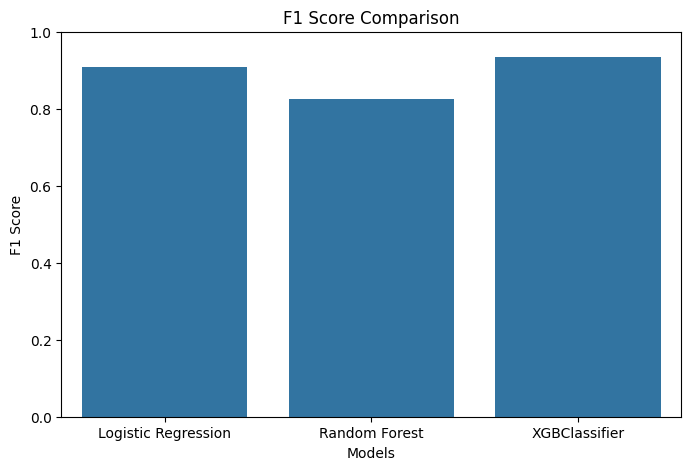

In [276]:
plt.figure(figsize=(8,5))
sns.barplot(x="model_name", y="f1", data=results_df)
plt.title("F1 Score Comparison")
plt.xlabel("Models")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.show()